<a href="https://colab.research.google.com/github/rdgreene/CNN-Workshop/blob/master/CNN_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title <--- Run this to download data and initialise your environment
%%capture

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# # cats vs dogs data prep
# !git clone https://ronangreene@bitbucket.org/ronangreene/cats_vs_dogs.git # clone repository with cats and dogs images
# !unzip cats_vs_dogs/data.zip # unzip data in clones repo
# !rm -r cats_vs_dogs # remove zipped data

# train_dir = 'data/train'
# val_dir = 'data/val'
# test_dir = 'data/test'

# mnist data prep
from keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

(X, y), _ = mnist.load_data()
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, target_size, target_size)
    input_shape = (1, 28, 28)
else:
    X = X.reshape(X.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)
X = X.astype('float32')
X /= 255

# convert class vectors to binary class matrices
y = to_categorical(y, 10)

mnist_data = (X, y)

In [7]:
y.shape

(60000, 10)

In [0]:
# from tensorflow.keras.datasets import mnist
# train_mnist = mnist.load_data()[train]
# test_mnist = mnist.load_data()[test]

## Task 1: Cat vs Dog Classification
For our first task, we have prepared a dataset containing labelled images of cats and dogs, and we will walk you through how to build an algorithm to differentiate between the two. A sample of these images is shown below.

### Intro to Keras
Keras is a Python package for deep learning package that cuts through a lot of the nitty gritty of programming deep learning models. There are a few different ways to use keras, but we will be using it to make sequential models, where we add layers to the model one at a time. You can find all of the keras documentation [here](https://keras.io/). We start importanting the various Keras sub-packages that we need for todays workshop.

In [9]:
# import required Keras sub-packages
%tensorflow_version 2.x
#import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

TensorFlow is already loaded. Please restart the runtime to change versions.


In [4]:
#@title A sample of our data! { vertical-output: true }
for animal in ['cats', 'dogs']:
  for i in ['2', '3', '8', '16']:
    plt.figure()
    plt.imshow(image.load_img(f'data/train/{animal}/{i}.jpg'))

NameError: ignored

<Figure size 432x288 with 0 Axes>

### Defining the Model Architecture
Once we've imported all the sub-packages we need, we can proceed to define a CNN model as a sequence of convolutional, maxpooling, and dense layers. Once this is done the model is compiled for use.

In [5]:
# this defines the input size of the images we will be feeding into our model
target_size = 64

# create an instance of a sequential model
model = models.Sequential()

# first block of convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_size, target_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# second block of convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# third block of convolutional layers
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# final dense layer for classification
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compile model ready for use
model.compile(
    loss='binary_crossentropy', # determines how errors are measured
    optimizer='adam', # determines gradient descent algorithm used
    metrics=['accuracy'] # metric used to monitor model performance during training
    )

# print out a summary of the compiled model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

### Setting up our data feed

Next we want to use Keras' ImageDataGenerator object to feeding image data into own CNN direct from the image directory. We set up flows from two seperate directories, one containing training images, and the other containing validation images. The training images are used for directly training the model, while that validation images are used to evaluate how well the trained model generalises to images it did not see during training!

In [7]:
# create image generator instance
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255) # TODO: move

# flow for training images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(target_size, target_size),
    batch_size=64,
    class_mode='binary'
    )

# flow for validation images
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(target_size, target_size),
    batch_size=32,
    class_mode='binary'
    )

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training the model

Once the model is compiled we can begin training the model. During this process the training images are fed through the model in batches, with the model predicting the class of each image in the batch. After processing a batch, the weights in the network are updated by backpropogating the prediction errors from that particular batch. This occurs for a total of 20 epochs, where one epoch is defined as a single pass over all the images in the training dataset. Throughout this whole process, the validation images are used to evaluate how well the model is doing at classifying images that it has not been exposed to during training. 

Note: It is usual to observe that the accuracy of the model when classifying validation images is less than that when classifying training images.

In [8]:
# train the model and record the results in history
history = model.fit_generator(
      train_generator,
      epochs=20,
      validation_data=validation_generator,
  )

Epoch 1/20
47/47 [==============================] - 25s 529ms/step - loss: 0.6861 - acc: 0.5453 - val_loss: 0.6683 - val_acc: 0.5950
Epoch 2/20
47/47 [==============================] - 23s 489ms/step - loss: 0.6561 - acc: 0.6073 - val_loss: 0.6625 - val_acc: 0.6150
Epoch 3/20
47/47 [==============================] - 23s 492ms/step - loss: 0.6071 - acc: 0.6670 - val_loss: 0.6283 - val_acc: 0.6590
Epoch 4/20
47/47 [==============================] - 23s 492ms/step - loss: 0.5552 - acc: 0.7143 - val_loss: 0.5818 - val_acc: 0.6940
Epoch 5/20
47/47 [==============================] - 23s 492ms/step - loss: 0.4996 - acc: 0.7543 - val_loss: 0.5850 - val_acc: 0.7020
Epoch 6/20
47/47 [==============================] - 23s 499ms/step - loss: 0.4790 - acc: 0.7727 - val_loss: 0.5500 - val_acc: 0.7290
Epoch 7/20
47/47 [==============================] - 23s 495ms/step - loss: 0.4043 - acc: 0.8143 - val_loss: 0.5353 - val_acc: 0.7600
Epoch 8/20
47/47 [==============================] - 23s 493ms/step - 

### Model evaluation

Now that the model has finished training, we can look at the results. Here we examine the accuracy of the model in classifying both training and validation images, as measured at the end of each epoch. We should observe that while performance on the training data is very strong, performance on the validation data plateaus after a number of epochs. This is a common problem in the machine learning field referred to as "overfitting". Overfitting is a problem as it suggests that some features learned by the model to discriminate between cats and dogs do not generalise well to the wider population.

Dealing with overfitting is beyond the scope of this workshop, however there are a number of established approaches for doing this. In the context of CNNs, "dropout" and image augmentation are generally the go-to choices. If you wish to expriement with these approaches, Keras provides easy functionality for appying both.

In instances where training performance was not so strong, we might also want to experiment with the architecture of our model and various other parameters, as these can all have a substantial impact on performance. A good first step here is to increase the "size" of the model, which can be done by adding additional layers, or increasing the size of the layers themselves.

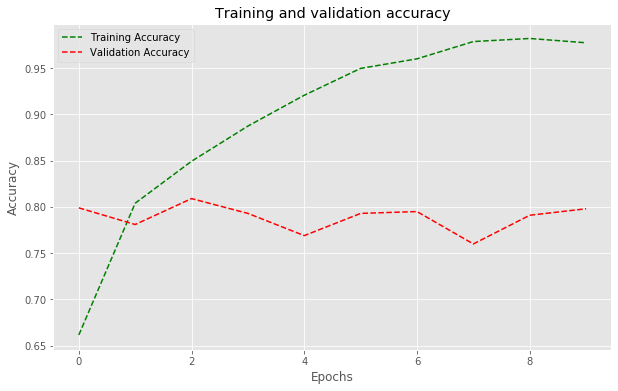

In [41]:
# get accuracy metrics recorded during training process
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
epochs = range(len(train_accuracy))

# plot accuracy recorded on training and validation test set after each epoch
plt.figure(figsize=(10,6))
plt.plot(epochs, train_accuracy, 'g--', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### Transfer Learning

An alternative approach to deep learning on image datasets is to use a model pre-trained on another image dataset and retrain the final layers for the specific task at hand. This approach is commonly known as "transfer learning".

Typically the pre-trained models used fro this have been previously trained on very large datasets, where the images are general enough that the feature identifying transformations learned by the lower layers can be of use for other image classification problems. This can be particularly beneficial when the dataset we have for a particular problem is small, which makes training good models from scratch is difficult.

Keras comes packaged a number of pre-trained CNNs in its applications sub-package. Here we make use of the [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) model, which was trained extensively on the ImageNet dataset (over 1 million labeled from 1000 different classes).

The basic workflow here consists of creating an instance of the pre-trained model with the final dense layers removed. We then create a new model using this pre-trained model as a base, adding our own dense layers on top. When training the model, the weights in the pre-trained part of the model are frozen, and we only learn the weights in the new dense layers that we have added.

In [24]:
# import the pretrained MobileNet model from the Keras applications library
from tensorflow.keras.applications import MobileNet

# create an instance of the MobileNet model with the final dense layers removed
mnet = MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# print out a summary of the compiled model
mnet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32) 

In [36]:
# build a new model using MobileNet as a base and adding our dense layers to be trained
model = models.Sequential()
model.add(mnet)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# freeze parameters in the MobileNet base so that only parameters in the dense layers are learned when training
mnet.trainable = False

# compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print out a summary of the compiled model
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 2, 2, 1024)        3228864   
_________________________________________________________________
flatten_7 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               1048832   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 4,277,953
Trainable params: 1,049,089
Non-trainable params: 3,228,864
_________________________________________________________________


In [37]:
# train the model and record the results in history
history = model.fit_generator(
  train_generator,
  epochs=10,
  validation_data=validation_generator
  )

Epoch 1/10
47/47 [==============================] - 37s 789ms/step - loss: 0.8457 - acc: 0.6617 - val_loss: 0.4389 - val_acc: 0.7990
Epoch 2/10
47/47 [==============================] - 34s 723ms/step - loss: 0.4083 - acc: 0.8040 - val_loss: 0.4867 - val_acc: 0.7810
Epoch 3/10
47/47 [==============================] - 34s 730ms/step - loss: 0.3286 - acc: 0.8493 - val_loss: 0.4091 - val_acc: 0.8090
Epoch 4/10
47/47 [==============================] - 34s 723ms/step - loss: 0.2639 - acc: 0.8873 - val_loss: 0.4667 - val_acc: 0.7930
Epoch 5/10
47/47 [==============================] - 34s 729ms/step - loss: 0.2086 - acc: 0.9207 - val_loss: 0.5277 - val_acc: 0.7690
Epoch 6/10
47/47 [==============================] - 35s 735ms/step - loss: 0.1532 - acc: 0.9497 - val_loss: 0.5167 - val_acc: 0.7930
Epoch 7/10
47/47 [==============================] - 34s 733ms/step - loss: 0.1125 - acc: 0.9600 - val_loss: 0.5656 - val_acc: 0.7950
Epoch 8/10
47/47 [==============================] - 35s 736ms/step - 

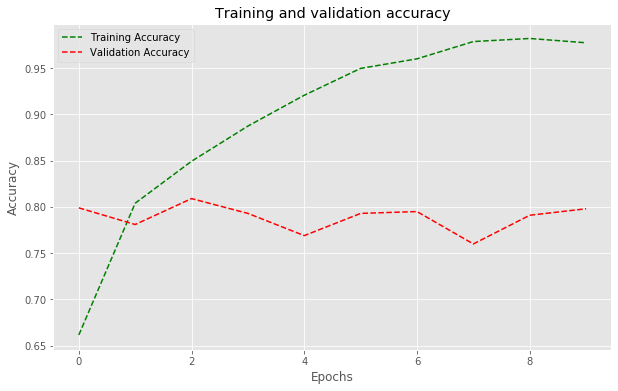

In [40]:
# get accuracy metrics recorded during training process
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
epochs = range(len(train_accuracy))

# plot accuracy recorded on training and validation test set after each epoch
plt.figure(figsize=(10,6))
plt.plot(epochs, train_accuracy, 'g--', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Task 2: Handwritten Digit Classification

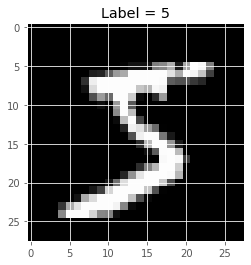

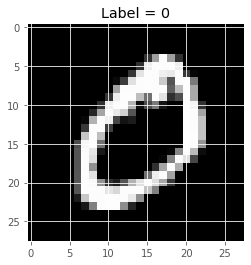

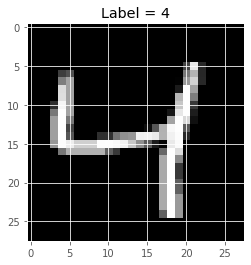

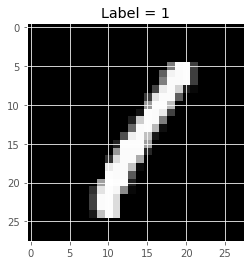

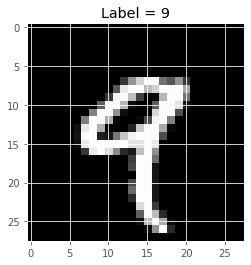

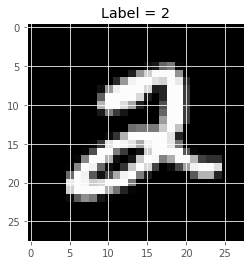

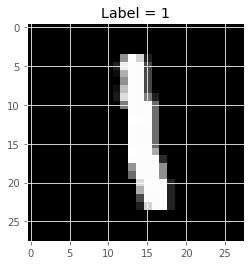

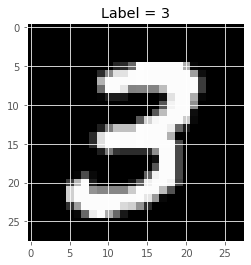

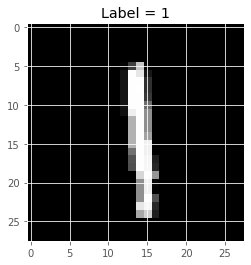

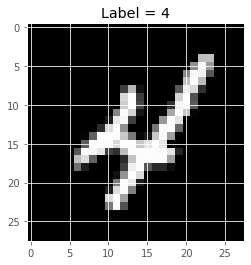

In [20]:
X, y = mnist_data

for i in range(10):
    plt.imshow(X[i].reshape(28, 28),cmap='gray')
    plt.title(f'Label = {np.argmax(y[i])}')
    plt.show()

In [0]:
# this defines the input size of the images we will be feeding into our model
target_size = 28

# 1. Create an instance of a sequential model

# 2. Add blocks of convolutional layers (use input_shape=(target_size, target_size, 1) for first convolusitonal layer)

# 3. Add dense layers for classification (layers.Dense(10, activation='softmax') for final layer)

# 4. Compile the model (use loss='categorical_crossentropy' as multiclass problem)

# train the model for 5 epochs using 20% of the data for validation
history = model.fit(X, y, epochs = 5, validation_split = 0.2)

# this will print the training results at the end
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
epochs = range(len(train_accuracy))
plt.figure(figsize=(10,6))
plt.plot(epochs, train_accuracy, 'g--', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()